## A Perceptron with PyTorch
This is my practice of the original by S. Raschka found [here](https://github.com/rasbt/deep-learning-book/blob/master/code/model_zoo/pytorch_ipynb/perceptron.ipynb)

In [44]:
import numpy as np
import torch
from sklearn.datasets.samples_generator import make_blobs

import matplotlib.pyplot as plt
%matplotlib inline

**Get and Prepare the Data**

In [70]:
# data = np.genfromtxt('perceptron_toydata.txt', delimiter='\t')
# X, y = data[:, :2], data[:, 2]


# I'm just going to create blobs with sklearn
X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                 random_state=42, cluster_std=3.0)

y = y.astype(np.int)


print('Class label counts: ', np.bincount(y))

# Shuffle order of elems
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(42)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

# Split train/test
X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize mean zero, unit variance
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts:  [50 50]


**Plot Featurs**

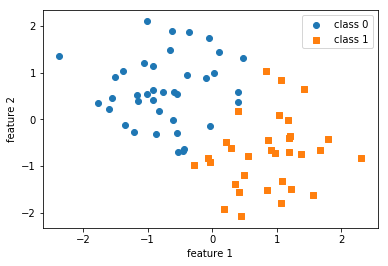

In [71]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
            label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
            label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

**Define the Perceptron Model**

In [72]:

def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)

class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1)
        self.bias = torch.zeros(1)
        
    def forward(self, x):
        # Linear step function
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = custom_where(linear > 0., 1, 0).float()
        return predictions
    
    def backward(self, x, y):
        """Error propagation"""
        predictions = self.forward(x)
        errors = y - predictions
        return errors
    
    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(y.size()[0]):
                errors = self.backward(x[i].view(1, self.num_features), y[i])
                self.weights += errors * x[i]
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y) / y.size()[0]
        return accuracy
        

**Train the Model**

In [76]:
# %%timeit # 26 ms local
ppn = Perceptron(num_features=2)

# Turn data into pytorch tensors
X_train_tensor, y_train_tensor = torch.Tensor(X_train), torch.Tensor(y_train)
ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:\n', 
      '    Weights %s\n' % ppn.weights,
      '    Bias %s' % ppn.bias)

Model parameters:
     Weights 
 4.8987
-3.1812
[torch.FloatTensor of size 2x1]

     Bias 
-1
[torch.FloatTensor of size 1]



**Evaluate the Model**

In [77]:
X_test_tensor, y_test_tensor = torch.Tensor(X_test), torch.Tensor(y_test)
test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print(' Accuracy = %.2f' % (test_acc*100))

 Accuracy = 100.00


**Plot Decision Boundary**

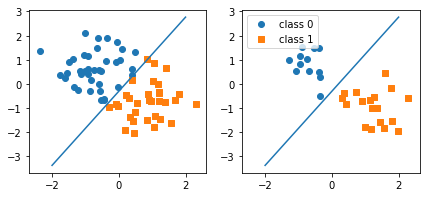

In [78]:
w, b = ppn.weights, ppn.bias

# To draw a boundary, create data for line
x_min = -2
y_min = (-w[0] * x_min) / w[1] - (b[0] / w[1])
x_max = 2
y_max = (-w[0] * x_max) / w[1] - (b[0] / w[1])

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
            label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
            label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], 
            label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], 
            label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()